In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0.0. Importando as Bibliotecas

In [2]:
#!pip install ordered_set

In [3]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import xgboost           as xgb

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition     import PCA
from sklearn.feature_selection import RFE
from sklearn.preprocessing     import OneHotEncoder, StandardScaler
from sklearn.linear_model      import LinearRegression
from sklearn.metrics           import mean_absolute_error,mean_squared_error
from ordered_set               import OrderedSet


#biblioteca de métricas
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

## 0.1 - Funções

# 1.0. Carregando o Dataset

In [5]:
df_treino = pd.read_csv('/content/drive/MyDrive/Meus documentos/codenation/enem-2/train.csv', low_memory=False)
df_teste = pd.read_csv('/content/drive/MyDrive/Meus documentos/codenation/enem-2/test.csv', low_memory=False)

# 2.0. Descrição dos Dados

In [6]:
df1 = df_treino.copy()
dft1 = df_teste.copy()

In [7]:
df1.sample(2)

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
12688,3545,76728da0c18cd3addbf49301b814d7672fe8f59e,2016,3128808,Guidoval,31,MG,21,F,0.0,1,1,3169901.0,Ubá,31.0,MG,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,0,0,...,A,B,B,A,A,A,A,A,B,A,A,C,A,B,B,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,5,5,5,5,NaN,A,A,A,A,A,C,A,A,A
6904,2328,5e5a24455ab69e5b0cff230361de0645e107e7ea,2016,1302603,Manaus,13,AM,16,F,0.0,3,1,1302603.0,Manaus,13.0,AM,3,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,...,A,B,A,B,A,B,A,B,C,B,A,E,B,B,B,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,2,5,5,2,5,NaN,B,A,A,A,C,A,A,A,A


In [8]:
dft1.sample(2)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
670,b547c6aea174382412cf6481827dfd8f26fc2e1b,33,RJ,20,M,1,1,1,2,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,470.5,583.2,540.9,0,1.0,120.0,120.0,120.0,120.0,100.0,580.0,A,D,C,A,B,C,NaN,A
2303,6ad6009351c9509a0651c645a9b1fe17511f21a8,42,SC,17,F,1,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,B,C,A,B,A,NaN,A


## 2.1 Dimensão dos Dados

In [9]:
print('Dimensão do Dataset de treino:\n')
print('Número de linhas do dataset: {} '.format(df1.shape[0]))
print('Número de colunas do dataset: {} '.format(df1.shape[1]))

print('\nDimensão do Dataset de teste:\n')
print('Número de linhas do dataset: {} '.format(dft1.shape[0]))
print('Número de colunas do dataset: {} '.format(dft1.shape[1]))

Dimensão do Dataset de treino:

Número de linhas do dataset: 13730 
Número de colunas do dataset: 167 

Dimensão do Dataset de teste:

Número de linhas do dataset: 4576 
Número de colunas do dataset: 47 


## 2.2 Verificando as colunas

In [10]:
# Verificando se as colunas de dataset de treino está inclusa no dataset de teste
print(set(dft1.columns).issubset(set(df1.columns)))

True


In [11]:
print('Quantidade de colunas iguais entre os datasets')
len(list(set(df1.columns).intersection(set(dft1.columns))))

Quantidade de colunas iguais entre os datasets


47

Temos 47 colunas em comum entre os datasets, vamos incluir a 'NU_NOTA_MT' no dataset de treino (df1)

## 2.3 Check NA

In [12]:
df1.isnull().sum()

Unnamed: 0                 0
NU_INSCRICAO               0
NU_ANO                     0
CO_MUNICIPIO_RESIDENCIA    0
NO_MUNICIPIO_RESIDENCIA    0
                          ..
Q046                       0
Q047                       0
Q048                       0
Q049                       0
Q050                       0
Length: 167, dtype: int64

In [13]:
dft1.isnull().sum()

NU_INSCRICAO                 0
CO_UF_RESIDENCIA             0
SG_UF_RESIDENCIA             0
NU_IDADE                     0
TP_SEXO                      0
TP_COR_RACA                  0
TP_NACIONALIDADE             0
TP_ST_CONCLUSAO              0
TP_ANO_CONCLUIU              0
TP_ESCOLA                    0
TP_ENSINO                 3096
IN_TREINEIRO                 0
TP_DEPENDENCIA_ADM_ESC    3096
IN_BAIXA_VISAO               0
IN_CEGUEIRA                  0
IN_SURDEZ                    0
IN_DISLEXIA                  0
IN_DISCALCULIA               0
IN_SABATISTA                 0
IN_GESTANTE                  0
IN_IDOSO                     0
TP_PRESENCA_CN               0
TP_PRESENCA_CH               0
TP_PRESENCA_LC               0
CO_PROVA_CN                  0
CO_PROVA_CH                  0
CO_PROVA_LC                  0
CO_PROVA_MT                  0
NU_NOTA_CN                1134
NU_NOTA_CH                1134
NU_NOTA_LC                1199
TP_LINGUA                    0
TP_STATU

In [14]:
(df1.shape,dft1.shape)

((13730, 167), (4576, 47))

## 2.4 - Transformações


In [15]:
# Transformando a coluna NU_INSCRICAO em index
df1 = df1.set_index('NU_INSCRICAO')
dft1 = dft1.set_index('NU_INSCRICAO')

In [16]:
# Realizando a interserção entre os dois modelos, e deixando o dataset de treino + target
cols = list(set(df1.columns).intersection(set(dft1.columns)))
cols.append('NU_NOTA_MT')
df2 = df1[cols].copy()
(df2.shape, dft1.shape)

((13730, 47), (4576, 46))

In [17]:
df2.columns

Index(['IN_DISLEXIA', 'TP_DEPENDENCIA_ADM_ESC', 'CO_PROVA_LC',
       'TP_ANO_CONCLUIU', 'NU_NOTA_LC', 'Q006', 'TP_ST_CONCLUSAO',
       'CO_UF_RESIDENCIA', 'NU_NOTA_CH', 'TP_COR_RACA', 'Q026',
       'TP_PRESENCA_LC', 'IN_CEGUEIRA', 'IN_IDOSO', 'TP_NACIONALIDADE',
       'SG_UF_RESIDENCIA', 'Q024', 'TP_STATUS_REDACAO', 'IN_SABATISTA',
       'NU_NOTA_COMP5', 'IN_DISCALCULIA', 'IN_GESTANTE', 'IN_BAIXA_VISAO',
       'TP_ESCOLA', 'NU_NOTA_COMP4', 'TP_PRESENCA_CN', 'NU_IDADE',
       'CO_PROVA_MT', 'Q027', 'NU_NOTA_COMP2', 'CO_PROVA_CH', 'TP_SEXO',
       'NU_NOTA_CN', 'IN_SURDEZ', 'CO_PROVA_CN', 'Q025', 'TP_ENSINO',
       'TP_PRESENCA_CH', 'NU_NOTA_COMP3', 'Q047', 'NU_NOTA_COMP1', 'Q001',
       'NU_NOTA_REDACAO', 'Q002', 'TP_LINGUA', 'IN_TREINEIRO', 'NU_NOTA_MT'],
      dtype='object')

## 2.5 DataFrame

In [18]:
# Creating DataFrame for Data Manipulation - Train Data
print('DATASET TREINO')
aux = pd.DataFrame({'column': df2.columns,
                    'dtype': df2.dtypes,
                    'missing': df2.isna().sum(),
                    'size': df2.shape[0],
                    'unique': df2.nunique(),
                    'missing_perc': ((df2.isna().sum() / df2.shape[0]) * 100).round(2)},
                    )
aux.sort_values('missing_perc', ascending=False)

DATASET TREINO


,column,dtype,missing,size,unique,missing_perc
TP_ENSINO,TP_ENSINO,float64,9448,13730,3,68.81
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,9448,13730,4,68.81
Q027,Q027,object,7373,13730,13,53.70
NU_NOTA_MT,NU_NOTA_MT,float64,3597,13730,3406,26.20
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,3597,13730,9,26.20
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,3597,13730,14,26.20
NU_NOTA_REDACAO,NU_NOTA_REDACAO,float64,3597,13730,53,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,3597,13730,15,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,3597,13730,13,26.20
NU_NOTA_COMP3,NU_NOTA_COMP3,float64,3597,13730,12,26.20


In [19]:
# Creating DataFrame for Data Manipulation - Train Data
print('DATASET TESTE')
aux = pd.DataFrame({'column': dft1.columns,
                    'dtype': dft1.dtypes,
                    'missing': dft1.isna().sum(),
                    'size': dft1.shape[0],
                    'unique': dft1.nunique(),
                    'missing_perc': ((dft1.isna().sum() / dft1.shape[0]) * 100).round(2)},
                    )
aux.sort_values('missing_perc', ascending=False)

DATASET TESTE


,column,dtype,missing,size,unique,missing_perc
TP_ENSINO,TP_ENSINO,float64,3096,4576,3,67.66
TP_DEPENDENCIA_ADM_ESC,TP_DEPENDENCIA_ADM_ESC,float64,3096,4576,4,67.66
Q027,Q027,object,2488,4576,13,54.37
NU_NOTA_COMP5,NU_NOTA_COMP5,float64,1199,4576,11,26.20
NU_NOTA_COMP2,NU_NOTA_COMP2,float64,1199,4576,10,26.20
NU_NOTA_LC,NU_NOTA_LC,float64,1199,4576,1839,26.20
TP_STATUS_REDACAO,TP_STATUS_REDACAO,float64,1199,4576,9,26.20
NU_NOTA_REDACAO,NU_NOTA_REDACAO,float64,1199,4576,44,26.20
NU_NOTA_COMP1,NU_NOTA_COMP1,float64,1199,4576,10,26.20
NU_NOTA_COMP4,NU_NOTA_COMP4,float64,1199,4576,11,26.20


Removendo as colunas de código por não apresentar relevância para o modelo de acordo com o dicionário de variáveis

# 3.0 Features

## 3.1 Filtrando Linhas

Não vai ser necessário realizar filtragem dos datasets

## 3.2 Filtrando Colunas

In [20]:
# Remoção das colunas  que não são relevantes 

#Códigos de provas
cod = ['CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT']
df2 = df2.drop(cod, axis=1)
dft1 = dft1.drop(cod, axis=1)

# Valores que não tem variância no Dataset
values_unique = ['IN_CEGUEIRA', 'IN_DISLEXIA', 'IN_DISCALCULIA','IN_IDOSO']
df2 = df2.drop(values_unique, axis=1)
dft1 = dft1.drop(values_unique, axis=1)

## 3.3 Tratando os NA

In [21]:
#Separando as variáveis dos dados de treino
atributo_cat1 = df2.select_dtypes(exclude = ['int64', 'float64'])
atributo_num1 = df2.select_dtypes(include = ['int64', 'float64'])

#Separando as variáveis dos dados de teste
atributo_cat2 = dft1.select_dtypes(exclude = ['int64', 'float64'])
atributo_num2 = dft1.select_dtypes(include = ['int64', 'float64'])

Dados de Treino

In [22]:
# Criando uma lista de colunas categóricas e numericas
list_cat1 = list(atributo_cat1.columns)
list_num1 = list(atributo_num1.columns)
# Completando dados faltantes com zero (0)
df2[list_cat1] = df2[list_cat1].fillna('0')
df2[list_num1] = df2[list_num1].fillna(0)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13730 entries, ed50e8aaa58e7a806c337585efee9ca41f1eb1ad to 0af8939c470a600b30bdaa80375ee0db848b0e35
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TP_DEPENDENCIA_ADM_ESC  13730 non-null  float64
 1   TP_ANO_CONCLUIU         13730 non-null  int64  
 2   NU_NOTA_LC              13730 non-null  float64
 3   Q006                    13730 non-null  object 
 4   TP_ST_CONCLUSAO         13730 non-null  int64  
 5   CO_UF_RESIDENCIA        13730 non-null  int64  
 6   NU_NOTA_CH              13730 non-null  float64
 7   TP_COR_RACA             13730 non-null  int64  
 8   Q026                    13730 non-null  object 
 9   TP_PRESENCA_LC          13730 non-null  int64  
 10  TP_NACIONALIDADE        13730 non-null  int64  
 11  SG_UF_RESIDENCIA        13730 non-null  object 
 12  Q024                    13730 non-null  object 
 13  TP_STATUS_REDACAO     

Dados de Teste

In [23]:
# Criando uma lista de colunas categóricas e numericas
list_cat2 = list(atributo_cat2.columns)
list_num2 = list(atributo_num2.columns)
# Completando dados faltantes com zero (0)
dft1[list_cat2] = dft1[list_cat2].fillna('0')
dft1[list_num2] = dft1[list_num2].fillna(0)

dft1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4576 entries, 73ff9fcc02f0a99919906c942c2e1a1042cdcf98 to adf0d15b54317b6564ef56dad2b775bbb0ef50cc
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CO_UF_RESIDENCIA        4576 non-null   int64  
 1   SG_UF_RESIDENCIA        4576 non-null   object 
 2   NU_IDADE                4576 non-null   int64  
 3   TP_SEXO                 4576 non-null   object 
 4   TP_COR_RACA             4576 non-null   int64  
 5   TP_NACIONALIDADE        4576 non-null   int64  
 6   TP_ST_CONCLUSAO         4576 non-null   int64  
 7   TP_ANO_CONCLUIU         4576 non-null   int64  
 8   TP_ESCOLA               4576 non-null   int64  
 9   TP_ENSINO               4576 non-null   float64
 10  IN_TREINEIRO            4576 non-null   int64  
 11  TP_DEPENDENCIA_ADM_ESC  4576 non-null   float64
 12  IN_BAIXA_VISAO          4576 non-null   int64  
 13  IN_SURDEZ              

# 4.0 Analise Exploratória

In [24]:
df3 = df2.copy()
dft2 = dft1.copy()

In [25]:
atributos_cat = df3.select_dtypes(exclude = ['int64', 'float64'])
atributos_num = df3.select_dtypes(include = ['int64', 'float64'])

## 4.1 Análise Univariada

### 4.1.1 Variável Numérica

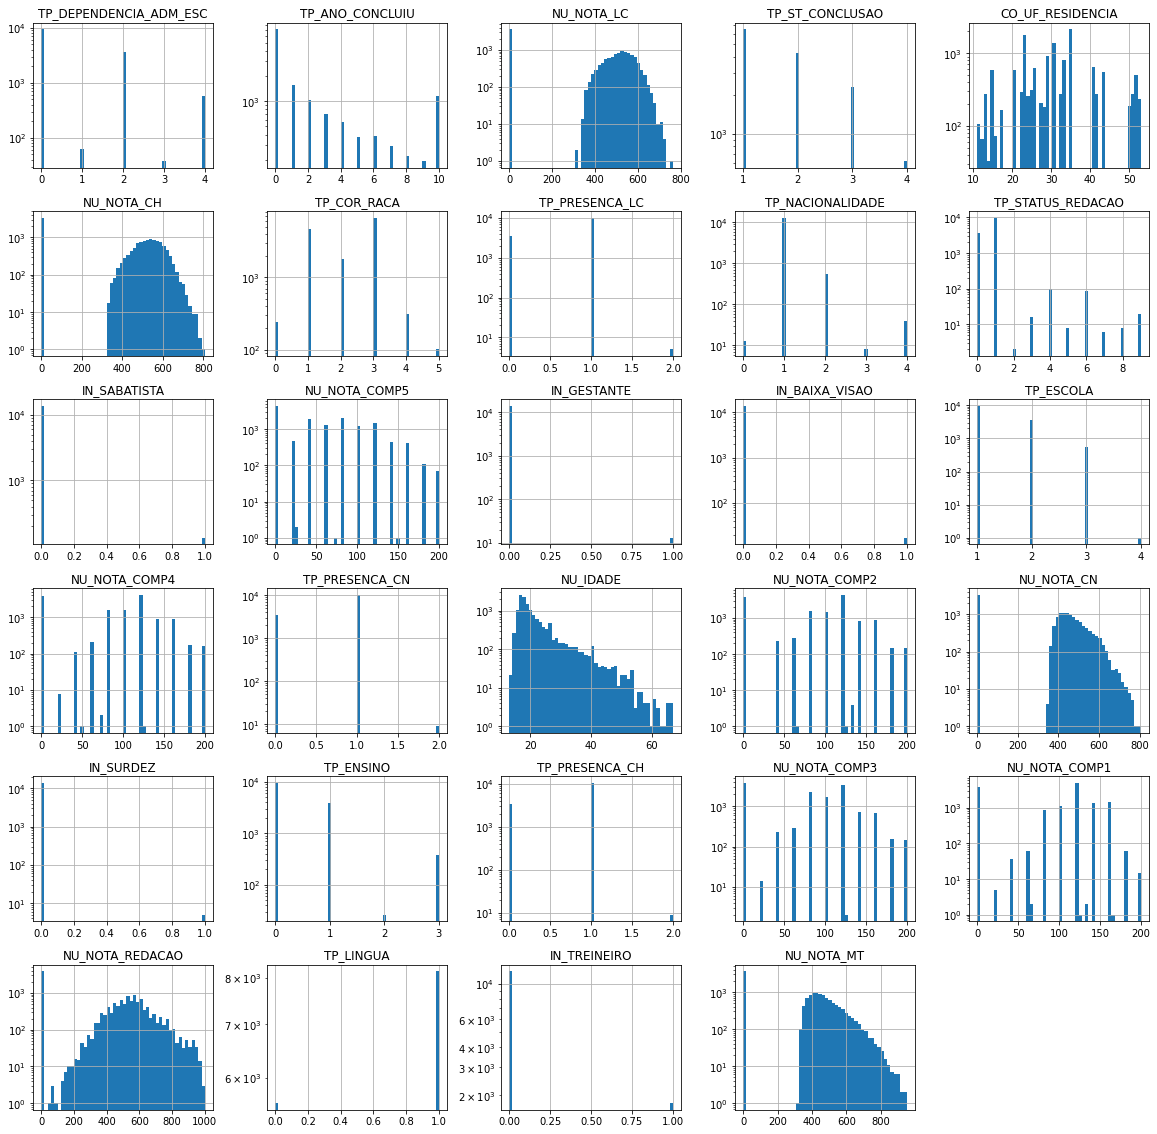

In [26]:
atributos_num.hist(bins=50,log=True,figsize=(20,20));

## 4.2 Análise Multivariada

### 4.2.1 Variável Numéricas

In [27]:
# Verificando todas as correlações com a variável alvo:
correlacao = pd.DataFrame(atributos_num.corr(method='pearson').NU_NOTA_MT)
correlacao['missing_perc'] = ((atributos_num.isna().sum() / atributos_num.shape[0]) * 100).round(2)
correlacao.sort_values('NU_NOTA_MT', ascending=False)

,NU_NOTA_MT,missing_perc
NU_NOTA_MT,1.000000,0.0
NU_NOTA_LC,0.943954,0.0
TP_PRESENCA_LC,0.923641,0.0
NU_NOTA_CN,0.907039,0.0
NU_NOTA_CH,0.903608,0.0
NU_NOTA_COMP1,0.882746,0.0
NU_NOTA_REDACAO,0.875929,0.0
TP_PRESENCA_CH,0.874764,0.0
TP_PRESENCA_CN,0.874764,0.0
NU_NOTA_COMP4,0.866827,0.0


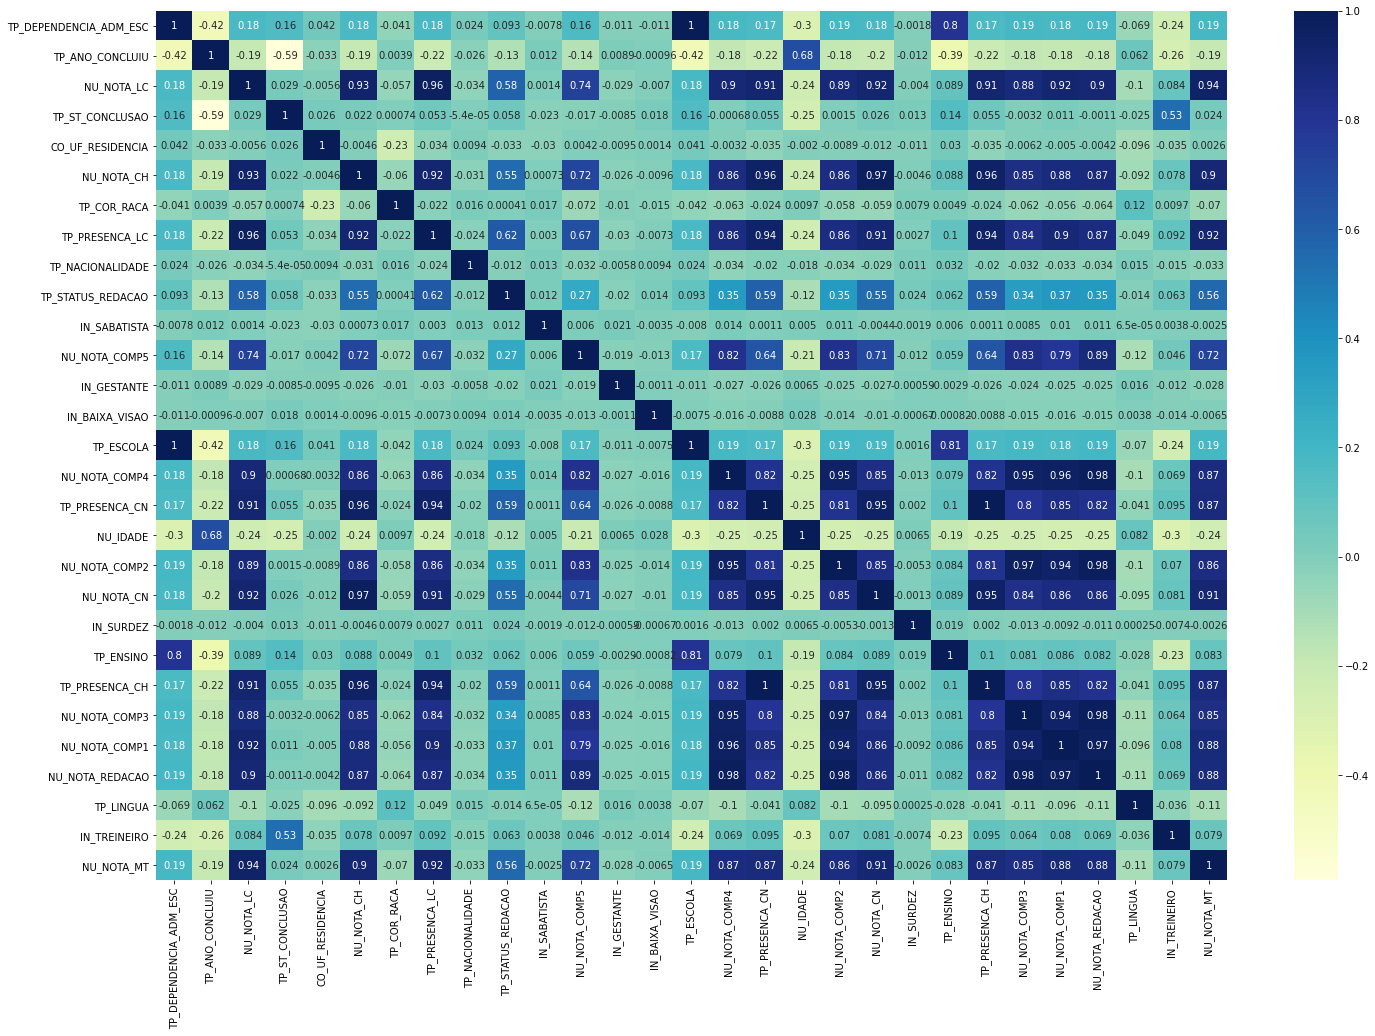

In [28]:
# Plotando as correlações em um heatmap
corr = atributos_num.corr(method='pearson')
ax = plt.subplots(figsize=(24, 16))
sns.heatmap(corr,  annot=True, cmap="YlGnBu");

### 4.2.2 Variável Categórica

In [29]:
#Verificando as variáveis categóricas
print('Data Manipulation - Treino Categóricas')
aux = pd.DataFrame({'column': atributos_cat.columns,
                    'dtype': atributos_cat  .dtypes,
                    'missing': atributos_cat.isna().sum(),
                    'size': atributos_cat.shape[0],
                    'unique': atributos_cat.nunique(),
                    'missing_perc': ((atributos_cat.isna().sum() / atributos_cat.shape[0]) * 100).round(2)
                   })
aux.sort_values('missing_perc', ascending=False)

Data Manipulation - Treino Categóricas


,column,dtype,missing,size,unique,missing_perc
Q006,Q006,object,0,13730,17,0.0
Q026,Q026,object,0,13730,3,0.0
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,13730,27,0.0
Q024,Q024,object,0,13730,5,0.0
Q027,Q027,object,0,13730,14,0.0
TP_SEXO,TP_SEXO,object,0,13730,2,0.0
Q025,Q025,object,0,13730,2,0.0
Q047,Q047,object,0,13730,5,0.0
Q001,Q001,object,0,13730,8,0.0
Q002,Q002,object,0,13730,8,0.0


#5.0 Preparação dos Dados

In [30]:
df3.dtypes

TP_DEPENDENCIA_ADM_ESC    float64
TP_ANO_CONCLUIU             int64
NU_NOTA_LC                float64
Q006                       object
TP_ST_CONCLUSAO             int64
CO_UF_RESIDENCIA            int64
NU_NOTA_CH                float64
TP_COR_RACA                 int64
Q026                       object
TP_PRESENCA_LC              int64
TP_NACIONALIDADE            int64
SG_UF_RESIDENCIA           object
Q024                       object
TP_STATUS_REDACAO         float64
IN_SABATISTA                int64
NU_NOTA_COMP5             float64
IN_GESTANTE                 int64
IN_BAIXA_VISAO              int64
TP_ESCOLA                   int64
NU_NOTA_COMP4             float64
TP_PRESENCA_CN              int64
NU_IDADE                    int64
Q027                       object
NU_NOTA_COMP2             float64
TP_SEXO                    object
NU_NOTA_CN                float64
IN_SURDEZ                   int64
Q025                       object
TP_ENSINO                 float64
TP_PRESENCA_CH

## 5.1 Preparação dos dados de Treino

In [32]:
# Selecionando os pré-processadores
encoder = OneHotEncoder(sparse=False)
scaler = StandardScaler()

In [33]:
# Aplicando o pré-processamento
for coluna in X.columns[0:]:
  try:
    X[coluna] = encoder.fit_transform(X[[coluna]])
    X[coluna] = scaler.fit_transform(X[[coluna]])
  except:
    print(f'Não foi possível realizar a operação para a coluna {coluna}')

## 5.2 Preparação dos Dados de Teste

In [34]:
# Aplicando o pré-processamento no dataset de teste:
for coluna in dft2.columns[0:]:
  try:
    dft2[coluna] = encoder.fit_transform(dft2[[coluna]])
    dft2[coluna] = scaler.fit_transform(dft2[[coluna]])
  except:
    print(f'Não foi possível realizar a operação para a coluna {coluna}')

In [35]:
X.head()

,TP_DEPENDENCIA_ADM_ESC,TP_ANO_CONCLUIU,NU_NOTA_LC,Q006,TP_ST_CONCLUSAO,CO_UF_RESIDENCIA,NU_NOTA_CH,TP_COR_RACA,Q026,TP_PRESENCA_LC,TP_NACIONALIDADE,SG_UF_RESIDENCIA,Q024,TP_STATUS_REDACAO,IN_SABATISTA,NU_NOTA_COMP5,IN_GESTANTE,IN_BAIXA_VISAO,TP_ESCOLA,NU_NOTA_COMP4,TP_PRESENCA_CN,NU_IDADE,Q027,NU_NOTA_COMP2,TP_SEXO,NU_NOTA_CN,IN_SURDEZ,Q025,TP_ENSINO,TP_PRESENCA_CH,NU_NOTA_COMP3,Q047,NU_NOTA_COMP1,Q001,NU_NOTA_REDACAO,Q002,TP_LINGUA,IN_TREINEIRO
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,0.673214,-1.050970,-0.596587,-0.192581,1.050970,-0.089041,-0.572809,-0.133665,-1.052352,-0.595240,-0.030785,-0.070027,1.117246,-0.595801,0.098902,-0.674128,0.030785,0.035209,0.673329,-0.624466,-0.571463,-0.008535,-1.076951,-0.622889,-1.273079,-0.573257,0.019087,1.149442,0.673214,-0.571463,-0.624578,0.413403,-0.623001,-0.27017,-0.622889,-0.221659,-0.827318,0.386319
2c3acac4b33ec2b195d77e7c04a2d75727fad723,-1.485411,0.951502,-0.596587,-0.192581,-0.951502,-0.089041,-0.572809,-0.133665,0.950253,-0.595240,-0.030785,-0.070027,1.117246,-0.595801,0.098902,-0.674128,0.030785,0.035209,-1.485159,-0.624466,-0.571463,-0.008535,0.928547,-0.622889,0.785497,-0.573257,0.019087,1.149442,-1.485411,-0.571463,-0.624578,0.413403,-0.623001,3.70138,-0.622889,4.511434,-0.827318,0.386319
f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,0.673214,0.951502,1.676203,-0.192581,-0.951502,-0.089041,1.745783,-0.133665,0.950253,1.679995,-0.030785,-0.070027,1.117246,1.678413,0.098902,1.483397,0.030785,0.035209,0.673329,1.601369,1.749894,-0.008535,0.928547,1.605423,0.785497,1.744417,0.019087,1.149442,0.673214,1.749894,1.601080,0.413403,1.605133,-0.27017,1.605423,-0.221659,-0.827318,0.386319
3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,0.673214,-1.050970,1.676203,-0.192581,1.050970,-0.089041,1.745783,7.481374,-1.052352,1.679995,-0.030785,-0.070027,-0.895058,1.678413,0.098902,1.483397,0.030785,0.035209,0.673329,1.601369,1.749894,-0.008535,-1.076951,1.605423,0.785497,1.744417,0.019087,-0.869987,0.673214,1.749894,1.601080,-2.418946,1.605133,-0.27017,1.605423,-0.221659,1.208724,0.386319
bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,0.673214,-1.050970,1.676203,-0.192581,1.050970,-0.089041,1.745783,-0.133665,-1.052352,1.679995,-0.030785,-0.070027,1.117246,1.678413,0.098902,1.483397,0.030785,0.035209,0.673329,1.601369,1.749894,-0.008535,-1.076951,1.605423,-1.273079,1.744417,0.019087,1.149442,0.673214,1.749894,1.601080,0.413403,1.605133,-0.27017,1.605423,-0.221659,-0.827318,0.386319


## 5.3 Escolhendo as Features

In [36]:
# Aplicando o PCA (Principal component analysis)
pca = PCA(0.95).fit(X)
pca.n_components_

19

In [37]:
# Criando estimador para aplicar o RFE 
estimator = LinearRegression()
rfe = RFE(estimator, 20, step=1)

In [38]:
# Seleção de features usando o RFE
rfe.fit(X, y)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=20, step=1, verbose=0)

In [39]:
col_test = pd.DataFrame({'column':X.columns,
              'rfe': rfe.support_})

In [40]:
rfe_selected = col_test.loc[col_test['rfe'] == True]
list_features1 = list(rfe_selected.column.values)
list_features1

['TP_DEPENDENCIA_ADM_ESC',
 'TP_ANO_CONCLUIU',
 'NU_NOTA_LC',
 'TP_ST_CONCLUSAO',
 'NU_NOTA_CH',
 'Q024',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP5',
 'TP_ESCOLA',
 'NU_NOTA_COMP4',
 'TP_PRESENCA_CN',
 'NU_NOTA_COMP2',
 'TP_SEXO',
 'Q025',
 'TP_ENSINO',
 'TP_PRESENCA_CH',
 'Q047',
 'NU_NOTA_COMP1',
 'NU_NOTA_REDACAO',
 'TP_LINGUA']

## 6.0 Modelo de Machine Learning

In [41]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X,y, test_size=0.3 ,random_state = 1606 )

## 6.1 Linear Regression Model

In [48]:
# model
LR = LinearRegression()
LR.fit(x_treino, y_treino)

# prediction
yhat_lr = LR.predict(x_teste)

#performance
result_linear = pd.DataFrame([{'Model': 'LinearRegresssion',
                                 'MAE': metrics.mean_absolute_error(y_teste, yhat_lr),
                                  'MSE': metrics.mean_squared_error(y_teste, yhat_lr),
                                  'R²' : r2_score(y_teste, yhat_lr)}])


result_linear


,Model,MAE,MSE,R²
0,LinearRegresssion,58.779051,6045.861218,0.882728


## 6.2 XGBoost

In [51]:
import xgboost as xgb

In [52]:
#model
xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytes=0.9).fit(x_treino,y_treino)

#prediction
yhat_xgb = xgb.predict(x_teste)

#performance
xgb_result = pd.DataFrame([{'Model': 'LinearRegresssion0',
                            'MAE': metrics.mean_absolute_error(y_teste, yhat_xgb),
                            'MSE': metrics.mean_squared_error(y_teste, yhat_xgb),
                            'R²' : r2_score(y_teste, yhat_xgb)}])
xgb_result

,Model,MAE,MSE,R²
0,LinearRegresssion0,53.384,6067.55565,0.882308


# 7.0 Enviar o resultado

In [ ]:
df1['NU_NOTA_MT'] = xgb.predict(yhat_xgb)

In [ ]:
answer = df1[['NU_INSCRICAO','NU_NOTA_MT']]
answer.to_csv('answer.csv', index=False)